In [3]:
import warnings
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

In [5]:
data = fdr.DataReader('KS11')
data 

Close     Open     High      Low       Volume  Change
Date                                                               
1981-05-01   123.60   123.60   123.60   123.60    3330000.0  0.0098
1981-05-02   123.50   123.50   123.50   123.50    2040000.0 -0.0008
1981-05-04   120.60   120.60   120.60   120.60    1930000.0 -0.0235
1981-05-06   120.70   120.70   120.70   120.70    1690000.0  0.0008
1981-05-07   119.30   119.30   119.30   119.30    1480000.0 -0.0116
...             ...      ...      ...      ...          ...     ...
2022-06-08  2626.15  2633.53  2639.52  2621.96  576390000.0 -0.0001
2022-06-09  2625.44  2618.92  2627.88  2606.61  814880000.0 -0.0003
2022-06-10  2595.87  2596.37  2602.80  2583.74  724090000.0 -0.0113
2022-06-13  2504.51  2550.21  2550.32  2504.51     622420.0 -0.0352
2022-06-14  2492.97  2472.96  2503.17  2457.39     661210.0 -0.0046

[10969 rows x 6 columns]

In [18]:
# 종가만 추출
close = data['Close']

# 비교 기준 구간
start_date = '2021-09-01'
end_date = '2021-09-16'

<AxesSubplot:xlabel='Date'>

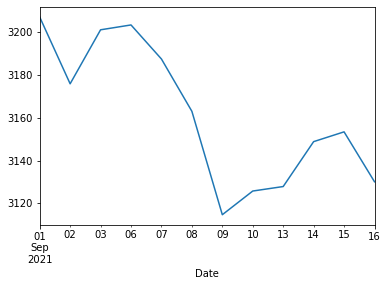

In [19]:
close[start_date:end_date].plot()

In [20]:
base = close[start_date:end_date]
base

Date
2021-09-01    3207.02
2021-09-02    3175.85
2021-09-03    3201.06
2021-09-06    3203.33
2021-09-07    3187.42
2021-09-08    3162.99
2021-09-09    3114.70
2021-09-10    3125.76
2021-09-13    3127.86
2021-09-14    3148.83
2021-09-15    3153.40
2021-09-16    3130.09
Name: Close, dtype: float64

In [21]:
base_norm = (base-base.min()) / (base.max()-base.min())
base_norm

Date
2021-09-01    1.000000
2021-09-02    0.662370
2021-09-03    0.935442
2021-09-06    0.960030
2021-09-07    0.787695
2021-09-08    0.523072
2021-09-09    0.000000
2021-09-10    0.119801
2021-09-13    0.142548
2021-09-14    0.369692
2021-09-15    0.419194
2021-09-16    0.166703
Name: Close, dtype: float64

In [22]:
# 윈도우 사이즈
window_size = len(base)
window_size

12

In [23]:
# 예측 기간
next_date = 5

# 검색 횟수
moving_cnt = len(close) - window_size - next_date - 1

In [24]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [25]:
sim_list = []

for i in range(moving_cnt):
    target = close[i:i+window_size]
    
    target_norm = (target - target.min()) / (target.max()-target.min())
    
    cos_similarity = cosine_similarity(base_norm, target_norm)
    
    sim_list.append(cos_similarity)

In [26]:
pd.Series(sim_list).sort_values(ascending=False).head(20)

10778    1.000000
2689     0.985459
3193     0.981478
4004     0.980018
922      0.979105
5701     0.978147
4570     0.977140
4560     0.977112
2349     0.975726
1598     0.975341
705      0.975245
8867     0.975099
9835     0.974511
5186     0.974506
4013     0.973608
5491     0.972963
2444     0.972133
8703     0.971858
7829     0.971592
1376     0.971498
dtype: float64

In [27]:
idx = 2689

top_ = close[idx: idx+window_size+next_date]
top_norm = (top_ - top_.min()) / (top_.max() - top_.min())

plt.plot(base_norm.values, label='base')
plt.plot(top_norm.values, label='target')
plt.axvline(x=len(base_norm)-1, c='r', linestyle='--')
plt.axvspan(len(base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
plt.legend()
plt.show()

# 클래스 구현 (주기를 바꾸고 싶으면 period 수정)

In [54]:
class PatternFinder():
    def __init__(self, period=5):
        self.period = period
        
    def set_stock(self, code: str):
        self.code = code
        self.data = fdr.DataReader(code)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data
    
    def search(self, start_date, end_date, threshold=0.98):
        base = self.close[start_date:end_date]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
        
#         display(base)
        
        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
        
        self.window_size = window_size
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        sim_list = []

        for i in range(moving_cnt):
            target = close[i:i+window_size]

            target_norm = (target - target.min()) / (target.max()-target.min())

            cos_similarity = cosine_similarity(base_norm, target_norm)

            sim_list.append(cos_similarity)
            
        return pd.Series(sim_list).sort_values(ascending=False)
    
    def plot_pattern(self, idx, period=5):
        if period != self.period:
            self.period = period
            
        top_ = close[idx: idx+window_size+next_date]
        top_norm = (top_ - top_.min()) / (top_.max() - top_.min())

        plt.plot(base_norm.values, label='base')
        plt.plot(top_norm.values, label='target')
        plt.axvline(x=len(base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        plt.legend()
        plt.show()
        
        preds = self.change[idx+self.window_size:idx+self.window_size+period]
#         display(preds)
        print(f'change pred: {preds.mean()*100} %')
        
    def stat_prediction(self, result, preiod=5):
        idx_list = list(result.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size:idx+self.window_size+period]
            mean_list.append(pred.mean())
            
        return np.array(mean_list)

In [55]:
p = PatternFinder()

In [56]:
p.set_stock('005930')

Open   High    Low  Close    Volume    Change
Date                                                      
1998-04-13   1457   1514   1428   1445    344060       NaN
1998-04-14   1437   1437   1307   1325    281250 -0.083045
1998-04-15   1298   1327   1276   1302    292720 -0.017358
1998-04-16   1301   1301   1207   1245    339630 -0.043779
1998-04-17   1245   1267   1229   1254    225160  0.007229
...           ...    ...    ...    ...       ...       ...
2022-06-08  65400  65700  65300  65300  12483180 -0.003053
2022-06-09  65100  65200  64500  65200  25790725 -0.001531
2022-06-10  64000  64400  63800  63800  22193552 -0.021472
2022-06-13  62400  62800  62100  62100  22157816 -0.026646
2022-06-14  61200  62200  61100  61900  23516715 -0.003221

[6000 rows x 6 columns]

In [57]:
result = p.search('2021-09-10', '2021-09-30')

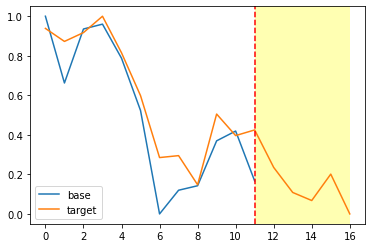

change pred: -0.8821073836499016 %


In [58]:
p.plot_pattern(2689)

In [59]:
result

2689    0.985459
3193    0.981478
4004    0.980018
dtype: float64

- base는 기준일의 주가 패턴을 나타냅니다.
- target은 기준일과 가장 유사한 패턴의 결과를 보여 줍니다. (향후 5일간)

# django로 구현할 때

## 종목 코드와 이름 목록 박스 만들 때 사용

### 코스피

In [60]:
import pandas as pd

In [61]:
kospi = pd.read_csv("kospi.csv")
kospi

Unnamed: 0         lst_name lst_number
0              0             삼성전자     005930
1              1         LG에너지솔루션     373220
2              2           SK하이닉스     000660
3              3         삼성바이오로직스     207940
4              4            삼성전자우     005935
...          ...              ...        ...
1798        1798     KBSTAR 모멘텀밸류     252720
1799        1799  KBSTAR 200에너지화학     284990
1800        1800  KBSTAR 200생활소비재     287330
1801        1801  KBSTAR 200경기소비재     287310
1802        1802    KBSTAR 200산업재     287320

[1803 rows x 3 columns]

In [62]:
lst = ["lst_name", "lst_number"]
kospi = kospi[lst]
kospi.columns = ["kospi_name", "kospi_number"]

In [63]:
kospi

kospi_name kospi_number
0                삼성전자       005930
1            LG에너지솔루션       373220
2              SK하이닉스       000660
3            삼성바이오로직스       207940
4               삼성전자우       005935
...               ...          ...
1798     KBSTAR 모멘텀밸류       252720
1799  KBSTAR 200에너지화학       284990
1800  KBSTAR 200생활소비재       287330
1801  KBSTAR 200경기소비재       287310
1802    KBSTAR 200산업재       287320

[1803 rows x 2 columns]

### 코스닥

In [64]:
kosdaq = pd.read_csv("kosdaq.csv")
kosdaq 

Unnamed: 0    lst_name lst_number
0              0      에코프로비엠     247540
1              1    셀트리온헬스케어     091990
2              2        엘앤에프     066970
3              3      카카오게임즈     293490
4              4         HLB     028300
...          ...         ...        ...
1552        1552  IBKS제17호스팩     405350
1553        1553   케이프이에스제4호     347140
1554        1554      대호특수강우     021045
1555        1555       소프트센우     032685
1556        1556     한국코퍼레이션     050540

[1557 rows x 3 columns]

In [65]:
lst = ["lst_name", "lst_number"]
kosdaq = kosdaq[lst]
kosdaq.columns = ["kosdaq_name", "kosdaq_number"]

In [66]:
kosdaq 

kosdaq_name kosdaq_number
0         에코프로비엠        247540
1       셀트리온헬스케어        091990
2           엘앤에프        066970
3         카카오게임즈        293490
4            HLB        028300
...          ...           ...
1552  IBKS제17호스팩        405350
1553   케이프이에스제4호        347140
1554      대호특수강우        021045
1555       소프트센우        032685
1556     한국코퍼레이션        050540

[1557 rows x 2 columns]